In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import optimizers
from keras import metrics

2023-10-05 21:12:17.019905: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-05 21:12:17.226216: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-05 21:12:17.887140: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# data = pd.read_csv("lsa64_dataset_best_80_fps_augmented.csv")

In [2]:
frames = 40

In [3]:
data = pd.read_csv(f"datasets/lsa64_dataset_openpose_{frames}_frames.csv")

In [4]:
data.category.unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59,  6, 60, 61, 62, 63, 64,  7,  8,  9])

In [5]:
def reshape_features_dataset(features):
    return features.reshape((int(features.shape[0]/frames), frames, features.shape[1]))

def reshape_target_dataset(target):
    return target.reshape((int(target.shape[0]/frames), frames))[:, 0]

In [6]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'category', 'video_name', 'frame',
       'hand_0_0_x', 'hand_0_0_y', 'hand_0_0_z', 'hand_0_1_x', 'hand_0_1_y',
       ...
       'pose_22_y', 'pose_22_z', 'pose_23_x', 'pose_23_y', 'pose_23_z',
       'pose_24_x', 'pose_24_y', 'pose_24_z', 'missing_hand', 'missing_face'],
      dtype='object', length=418)

In [8]:
z_columns = [i for i in list(data.columns) if i.endswith("_z")]

In [12]:
categories = list(data["category"].unique())

In [13]:
data["category_index"] = data["category"].apply(lambda i: categories.index(i))

In [14]:
columns_to_drop = ["Unnamed: 0", "Unnamed: 0.1", "category", "category_index", "video_name", "frame", "missing_hand", "missing_face", "person"] + z_columns
# columns_to_drop = ["Unnamed: 0", "Unnamed: 0.1", "category", "category_index", "video_name", "frame"]
predict_columns = "category_index"

In [22]:
# LOPO
num_validation = 2
num_test = 1
data["person"] = data["video_name"].apply(lambda i: i.split("_")[1])
people = data["person"].unique()
validate_people = people[-num_validation:]
test_people = people[-(num_validation + num_test):-num_validation]
train_people = people[:-(num_validation + num_test)]

train_dataset = data[data["person"].isin(train_people)]
test_dataset = data[data["person"].isin(test_people)]
validate_dataset = data[data["person"].isin(validate_people)]

# Removing data augmentation for test and validation
test_dataset = test_dataset[(~test_dataset["video_name"].str.contains("augmented"))]
validate_dataset = validate_dataset[(~validate_dataset["video_name"].str.contains("augmented"))]

train_features = train_dataset.drop(columns_to_drop + ["person"], axis=1).values
train_features = reshape_features_dataset(train_features)
train_target = train_dataset[predict_columns].values
train_target = reshape_target_dataset(train_target)

test_features = test_dataset.drop(columns_to_drop + ["person"], axis=1).values
test_features = reshape_features_dataset(test_features)
test_target = test_dataset[predict_columns].values
test_target = reshape_target_dataset(test_target)

validate_features = validate_dataset.drop(columns_to_drop + ["person"], axis=1).values
validate_features = reshape_features_dataset(validate_features)
validate_target = validate_dataset[predict_columns].values
validate_target = reshape_target_dataset(validate_target)

In [49]:
# Train test split
features = data.drop(columns_to_drop, axis=1).values
target = data[predict_columns].values

features = reshape_features_dataset(features)
target = reshape_target_dataset(target)

train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.4)

In [23]:
train_features.shape

(2240, 40, 274)

In [24]:
test_target.shape

(320,)

In [25]:
model = Sequential()
model.add(LSTM(64, input_shape=(frames, train_features.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Dense(64, activation='softmax'))

2023-10-05 21:16:32.510944: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-05 21:16:32.622172: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-05 21:16:32.622313: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-05 21:16:32.624085: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-05 21:16:32.624222: I tensorflow/compile

In [28]:
# Compile the model
optimizer = optimizers.Adam(learning_rate=10e-4, weight_decay=10e-6)
# optimizer = optimizers.SGD(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', 'sparse_categorical_accuracy'])

In [29]:
# Train the model
result = model.fit(train_features, train_target, epochs=1000, batch_size=32, validation_data=(validate_features, validate_target))

Epoch 1/1000


2023-10-05 21:17:59.537431: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-05 21:17:59.702582: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-05 21:17:59.707320: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f27b9074980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-05 21:17:59.707338: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2023-10-05 21:17:59.734622: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-05 21:17:59.909100: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2023-10-05 21:17:59.981618: I ./t

70/70 [==============================] - 5s 18ms/step - loss: 4.1079 - accuracy: 0.0263 - sparse_categorical_accuracy: 0.0263 - val_loss: 3.8926 - val_accuracy: 0.0312 - val_sparse_categorical_accuracy: 0.0312
Epoch 2/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.6682 - accuracy: 0.0518 - sparse_categorical_accuracy: 0.0518 - val_loss: 3.3545 - val_accuracy: 0.0500 - val_sparse_categorical_accuracy: 0.0500
Epoch 3/1000
70/70 [==============================] - 1s 9ms/step - loss: 3.2932 - accuracy: 0.0964 - sparse_categorical_accuracy: 0.0964 - val_loss: 2.9307 - val_accuracy: 0.1141 - val_sparse_categorical_accuracy: 0.1141
Epoch 4/1000
70/70 [==============================] - 1s 10ms/step - loss: 2.9805 - accuracy: 0.1192 - sparse_categorical_accuracy: 0.1192 - val_loss: 2.7220 - val_accuracy: 0.1422 - val_sparse_categorical_accuracy: 0.1422
Epoch 5/1000
70/70 [==============================] - 1s 10ms/step - loss: 2.8356 - accuracy: 0.1281 - sparse_categorical_a

Epoch 38/1000
70/70 [==============================] - 1s 10ms/step - loss: 1.3720 - accuracy: 0.4808 - sparse_categorical_accuracy: 0.4808 - val_loss: 1.5380 - val_accuracy: 0.4656 - val_sparse_categorical_accuracy: 0.4656
Epoch 39/1000
70/70 [==============================] - 1s 10ms/step - loss: 1.3671 - accuracy: 0.5000 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.6503 - val_accuracy: 0.4062 - val_sparse_categorical_accuracy: 0.4062
Epoch 40/1000
70/70 [==============================] - 1s 10ms/step - loss: 1.4894 - accuracy: 0.4594 - sparse_categorical_accuracy: 0.4594 - val_loss: 1.5400 - val_accuracy: 0.4750 - val_sparse_categorical_accuracy: 0.4750
Epoch 41/1000
70/70 [==============================] - 1s 9ms/step - loss: 1.3073 - accuracy: 0.5259 - sparse_categorical_accuracy: 0.5259 - val_loss: 1.5481 - val_accuracy: 0.4109 - val_sparse_categorical_accuracy: 0.4109
Epoch 42/1000
70/70 [==============================] - 1s 10ms/step - loss: 1.3889 - accuracy: 0.4969 - s

Epoch 75/1000
70/70 [==============================] - 1s 11ms/step - loss: 1.0992 - accuracy: 0.6272 - sparse_categorical_accuracy: 0.6272 - val_loss: 1.5907 - val_accuracy: 0.4625 - val_sparse_categorical_accuracy: 0.4625
Epoch 76/1000
70/70 [==============================] - 1s 11ms/step - loss: 1.0026 - accuracy: 0.6415 - sparse_categorical_accuracy: 0.6415 - val_loss: 1.5153 - val_accuracy: 0.5500 - val_sparse_categorical_accuracy: 0.5500
Epoch 77/1000
70/70 [==============================] - 1s 11ms/step - loss: 1.0396 - accuracy: 0.6237 - sparse_categorical_accuracy: 0.6237 - val_loss: 1.5965 - val_accuracy: 0.4703 - val_sparse_categorical_accuracy: 0.4703
Epoch 78/1000
70/70 [==============================] - 1s 11ms/step - loss: 0.9552 - accuracy: 0.6496 - sparse_categorical_accuracy: 0.6496 - val_loss: 1.4712 - val_accuracy: 0.5297 - val_sparse_categorical_accuracy: 0.5297
Epoch 79/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.9102 - accuracy: 0.6670 - 

70/70 [==============================] - 1s 9ms/step - loss: 0.6858 - accuracy: 0.7527 - sparse_categorical_accuracy: 0.7527 - val_loss: 1.4138 - val_accuracy: 0.5484 - val_sparse_categorical_accuracy: 0.5484
Epoch 112/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.6361 - accuracy: 0.7679 - sparse_categorical_accuracy: 0.7679 - val_loss: 1.4531 - val_accuracy: 0.5609 - val_sparse_categorical_accuracy: 0.5609
Epoch 113/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.6297 - accuracy: 0.7647 - sparse_categorical_accuracy: 0.7647 - val_loss: 1.2616 - val_accuracy: 0.6250 - val_sparse_categorical_accuracy: 0.6250
Epoch 114/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.6397 - accuracy: 0.7603 - sparse_categorical_accuracy: 0.7603 - val_loss: 1.6747 - val_accuracy: 0.5312 - val_sparse_categorical_accuracy: 0.5312
Epoch 115/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.7220 - accuracy: 0.7473 - sparse_categor

70/70 [==============================] - 1s 11ms/step - loss: 0.4740 - accuracy: 0.8290 - sparse_categorical_accuracy: 0.8290 - val_loss: 1.5117 - val_accuracy: 0.6266 - val_sparse_categorical_accuracy: 0.6266
Epoch 148/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.5128 - accuracy: 0.8156 - sparse_categorical_accuracy: 0.8156 - val_loss: 1.5417 - val_accuracy: 0.6094 - val_sparse_categorical_accuracy: 0.6094
Epoch 149/1000
70/70 [==============================] - 1s 11ms/step - loss: 0.4884 - accuracy: 0.8232 - sparse_categorical_accuracy: 0.8232 - val_loss: 1.6130 - val_accuracy: 0.6125 - val_sparse_categorical_accuracy: 0.6125
Epoch 150/1000
70/70 [==============================] - 1s 11ms/step - loss: 0.4922 - accuracy: 0.8290 - sparse_categorical_accuracy: 0.8290 - val_loss: 1.7604 - val_accuracy: 0.5719 - val_sparse_categorical_accuracy: 0.5719
Epoch 151/1000
70/70 [==============================] - 1s 11ms/step - loss: 0.5041 - accuracy: 0.8121 - sparse_cat

70/70 [==============================] - 1s 9ms/step - loss: 0.5173 - accuracy: 0.8246 - sparse_categorical_accuracy: 0.8246 - val_loss: 1.5615 - val_accuracy: 0.6234 - val_sparse_categorical_accuracy: 0.6234
Epoch 184/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.5680 - accuracy: 0.8156 - sparse_categorical_accuracy: 0.8156 - val_loss: 1.6415 - val_accuracy: 0.6375 - val_sparse_categorical_accuracy: 0.6375
Epoch 185/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.4200 - accuracy: 0.8545 - sparse_categorical_accuracy: 0.8545 - val_loss: 1.5444 - val_accuracy: 0.6641 - val_sparse_categorical_accuracy: 0.6641
Epoch 186/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.3438 - accuracy: 0.8737 - sparse_categorical_accuracy: 0.8737 - val_loss: 1.5773 - val_accuracy: 0.6172 - val_sparse_categorical_accuracy: 0.6172
Epoch 187/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.3024 - accuracy: 0.8955 - sparse_catego

70/70 [==============================] - 1s 10ms/step - loss: 0.2682 - accuracy: 0.9067 - sparse_categorical_accuracy: 0.9067 - val_loss: 1.6376 - val_accuracy: 0.6719 - val_sparse_categorical_accuracy: 0.6719
Epoch 220/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.3172 - accuracy: 0.8879 - sparse_categorical_accuracy: 0.8879 - val_loss: 1.7696 - val_accuracy: 0.6484 - val_sparse_categorical_accuracy: 0.6484
Epoch 221/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.2706 - accuracy: 0.9054 - sparse_categorical_accuracy: 0.9054 - val_loss: 1.8354 - val_accuracy: 0.6562 - val_sparse_categorical_accuracy: 0.6562
Epoch 222/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.2906 - accuracy: 0.8982 - sparse_categorical_accuracy: 0.8982 - val_loss: 1.7931 - val_accuracy: 0.6438 - val_sparse_categorical_accuracy: 0.6438
Epoch 223/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.3024 - accuracy: 0.8991 - sparse_cat

70/70 [==============================] - 1s 9ms/step - loss: 0.2231 - accuracy: 0.9295 - sparse_categorical_accuracy: 0.9295 - val_loss: 1.7757 - val_accuracy: 0.6672 - val_sparse_categorical_accuracy: 0.6672
Epoch 256/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.3150 - accuracy: 0.9013 - sparse_categorical_accuracy: 0.9013 - val_loss: 1.9074 - val_accuracy: 0.6469 - val_sparse_categorical_accuracy: 0.6469
Epoch 257/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.2393 - accuracy: 0.9170 - sparse_categorical_accuracy: 0.9170 - val_loss: 2.0428 - val_accuracy: 0.6172 - val_sparse_categorical_accuracy: 0.6172
Epoch 258/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.2579 - accuracy: 0.9121 - sparse_categorical_accuracy: 0.9121 - val_loss: 1.8415 - val_accuracy: 0.6562 - val_sparse_categorical_accuracy: 0.6562
Epoch 259/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.2652 - accuracy: 0.9098 - sparse_categ

70/70 [==============================] - 1s 12ms/step - loss: 0.1771 - accuracy: 0.9330 - sparse_categorical_accuracy: 0.9330 - val_loss: 1.9477 - val_accuracy: 0.6484 - val_sparse_categorical_accuracy: 0.6484
Epoch 292/1000
70/70 [==============================] - 1s 12ms/step - loss: 0.2068 - accuracy: 0.9290 - sparse_categorical_accuracy: 0.9290 - val_loss: 2.0023 - val_accuracy: 0.6516 - val_sparse_categorical_accuracy: 0.6516
Epoch 293/1000
70/70 [==============================] - 1s 12ms/step - loss: 0.1920 - accuracy: 0.9375 - sparse_categorical_accuracy: 0.9375 - val_loss: 1.9466 - val_accuracy: 0.6609 - val_sparse_categorical_accuracy: 0.6609
Epoch 294/1000
70/70 [==============================] - 1s 12ms/step - loss: 0.2340 - accuracy: 0.9228 - sparse_categorical_accuracy: 0.9228 - val_loss: 2.1009 - val_accuracy: 0.6484 - val_sparse_categorical_accuracy: 0.6484
Epoch 295/1000
70/70 [==============================] - 1s 12ms/step - loss: 0.2503 - accuracy: 0.9094 - sparse_cat

70/70 [==============================] - 1s 9ms/step - loss: 0.2050 - accuracy: 0.9339 - sparse_categorical_accuracy: 0.9339 - val_loss: 1.9274 - val_accuracy: 0.6500 - val_sparse_categorical_accuracy: 0.6500
Epoch 328/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.4345 - accuracy: 0.8652 - sparse_categorical_accuracy: 0.8652 - val_loss: 1.8040 - val_accuracy: 0.6719 - val_sparse_categorical_accuracy: 0.6719
Epoch 329/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.2718 - accuracy: 0.9080 - sparse_categorical_accuracy: 0.9080 - val_loss: 1.9223 - val_accuracy: 0.6578 - val_sparse_categorical_accuracy: 0.6578
Epoch 330/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.2888 - accuracy: 0.9031 - sparse_categorical_accuracy: 0.9031 - val_loss: 1.8890 - val_accuracy: 0.6875 - val_sparse_categorical_accuracy: 0.6875
Epoch 331/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.2217 - accuracy: 0.9268 - sparse_categori

70/70 [==============================] - 1s 11ms/step - loss: 0.1706 - accuracy: 0.9464 - sparse_categorical_accuracy: 0.9464 - val_loss: 1.9792 - val_accuracy: 0.6922 - val_sparse_categorical_accuracy: 0.6922
Epoch 364/1000
70/70 [==============================] - 1s 12ms/step - loss: 0.6892 - accuracy: 0.8384 - sparse_categorical_accuracy: 0.8384 - val_loss: 1.8340 - val_accuracy: 0.6641 - val_sparse_categorical_accuracy: 0.6641
Epoch 365/1000
70/70 [==============================] - 1s 12ms/step - loss: 0.1886 - accuracy: 0.9415 - sparse_categorical_accuracy: 0.9415 - val_loss: 1.8673 - val_accuracy: 0.6609 - val_sparse_categorical_accuracy: 0.6609
Epoch 366/1000
70/70 [==============================] - 1s 12ms/step - loss: 0.1434 - accuracy: 0.9531 - sparse_categorical_accuracy: 0.9531 - val_loss: 1.9177 - val_accuracy: 0.6797 - val_sparse_categorical_accuracy: 0.6797
Epoch 367/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.1653 - accuracy: 0.9460 - sparse_cat

70/70 [==============================] - 1s 12ms/step - loss: 0.2653 - accuracy: 0.9125 - sparse_categorical_accuracy: 0.9125 - val_loss: 2.0322 - val_accuracy: 0.6531 - val_sparse_categorical_accuracy: 0.6531
Epoch 400/1000
70/70 [==============================] - 1s 12ms/step - loss: 0.2272 - accuracy: 0.9272 - sparse_categorical_accuracy: 0.9272 - val_loss: 1.7678 - val_accuracy: 0.7078 - val_sparse_categorical_accuracy: 0.7078
Epoch 401/1000
70/70 [==============================] - 1s 12ms/step - loss: 0.1221 - accuracy: 0.9607 - sparse_categorical_accuracy: 0.9607 - val_loss: 1.9177 - val_accuracy: 0.6969 - val_sparse_categorical_accuracy: 0.6969
Epoch 402/1000
70/70 [==============================] - 1s 12ms/step - loss: 0.1345 - accuracy: 0.9580 - sparse_categorical_accuracy: 0.9580 - val_loss: 2.3252 - val_accuracy: 0.6687 - val_sparse_categorical_accuracy: 0.6687
Epoch 403/1000
70/70 [==============================] - 1s 12ms/step - loss: 0.1652 - accuracy: 0.9424 - sparse_cat

70/70 [==============================] - 1s 12ms/step - loss: 0.1290 - accuracy: 0.9563 - sparse_categorical_accuracy: 0.9563 - val_loss: 1.9257 - val_accuracy: 0.6641 - val_sparse_categorical_accuracy: 0.6641
Epoch 436/1000
70/70 [==============================] - 1s 11ms/step - loss: 0.1161 - accuracy: 0.9612 - sparse_categorical_accuracy: 0.9612 - val_loss: 1.8885 - val_accuracy: 0.6719 - val_sparse_categorical_accuracy: 0.6719
Epoch 437/1000
70/70 [==============================] - 1s 11ms/step - loss: 0.1120 - accuracy: 0.9656 - sparse_categorical_accuracy: 0.9656 - val_loss: 2.1947 - val_accuracy: 0.6578 - val_sparse_categorical_accuracy: 0.6578
Epoch 438/1000
70/70 [==============================] - 1s 11ms/step - loss: 0.1420 - accuracy: 0.9545 - sparse_categorical_accuracy: 0.9545 - val_loss: 2.0621 - val_accuracy: 0.6797 - val_sparse_categorical_accuracy: 0.6797
Epoch 439/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.1199 - accuracy: 0.9580 - sparse_cat

70/70 [==============================] - 1s 11ms/step - loss: 0.1983 - accuracy: 0.9348 - sparse_categorical_accuracy: 0.9348 - val_loss: 1.9513 - val_accuracy: 0.6828 - val_sparse_categorical_accuracy: 0.6828
Epoch 472/1000
70/70 [==============================] - 1s 11ms/step - loss: 0.1500 - accuracy: 0.9469 - sparse_categorical_accuracy: 0.9469 - val_loss: 1.6640 - val_accuracy: 0.7188 - val_sparse_categorical_accuracy: 0.7188
Epoch 473/1000
70/70 [==============================] - 1s 11ms/step - loss: 0.1227 - accuracy: 0.9576 - sparse_categorical_accuracy: 0.9576 - val_loss: 1.8150 - val_accuracy: 0.7078 - val_sparse_categorical_accuracy: 0.7078
Epoch 474/1000
70/70 [==============================] - 1s 12ms/step - loss: 0.2855 - accuracy: 0.9196 - sparse_categorical_accuracy: 0.9196 - val_loss: 1.9698 - val_accuracy: 0.6687 - val_sparse_categorical_accuracy: 0.6687
Epoch 475/1000
70/70 [==============================] - 1s 11ms/step - loss: 0.1945 - accuracy: 0.9335 - sparse_cat

70/70 [==============================] - 1s 10ms/step - loss: 0.1097 - accuracy: 0.9665 - sparse_categorical_accuracy: 0.9665 - val_loss: 2.2160 - val_accuracy: 0.6703 - val_sparse_categorical_accuracy: 0.6703
Epoch 508/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.2746 - accuracy: 0.9241 - sparse_categorical_accuracy: 0.9241 - val_loss: 2.1215 - val_accuracy: 0.6875 - val_sparse_categorical_accuracy: 0.6875
Epoch 509/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.2414 - accuracy: 0.9201 - sparse_categorical_accuracy: 0.9201 - val_loss: 1.9224 - val_accuracy: 0.6750 - val_sparse_categorical_accuracy: 0.6750
Epoch 510/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.2891 - accuracy: 0.9219 - sparse_categorical_accuracy: 0.9219 - val_loss: 1.8149 - val_accuracy: 0.6812 - val_sparse_categorical_accuracy: 0.6812
Epoch 511/1000
70/70 [==============================] - 1s 12ms/step - loss: 0.1344 - accuracy: 0.9536 - sparse_cat

70/70 [==============================] - 1s 10ms/step - loss: 0.1360 - accuracy: 0.9504 - sparse_categorical_accuracy: 0.9504 - val_loss: 2.1783 - val_accuracy: 0.6547 - val_sparse_categorical_accuracy: 0.6547
Epoch 544/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.3369 - accuracy: 0.9080 - sparse_categorical_accuracy: 0.9080 - val_loss: 1.9376 - val_accuracy: 0.6891 - val_sparse_categorical_accuracy: 0.6891
Epoch 545/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.2242 - accuracy: 0.9321 - sparse_categorical_accuracy: 0.9321 - val_loss: 1.8693 - val_accuracy: 0.6891 - val_sparse_categorical_accuracy: 0.6891
Epoch 546/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.1365 - accuracy: 0.9540 - sparse_categorical_accuracy: 0.9540 - val_loss: 1.9457 - val_accuracy: 0.7016 - val_sparse_categorical_accuracy: 0.7016
Epoch 547/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.0982 - accuracy: 0.9701 - sparse_catego

70/70 [==============================] - 1s 9ms/step - loss: 0.1316 - accuracy: 0.9652 - sparse_categorical_accuracy: 0.9652 - val_loss: 2.4061 - val_accuracy: 0.6672 - val_sparse_categorical_accuracy: 0.6672
Epoch 580/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.0951 - accuracy: 0.9683 - sparse_categorical_accuracy: 0.9683 - val_loss: 2.5410 - val_accuracy: 0.6828 - val_sparse_categorical_accuracy: 0.6828
Epoch 581/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.1410 - accuracy: 0.9513 - sparse_categorical_accuracy: 0.9513 - val_loss: 2.0210 - val_accuracy: 0.6812 - val_sparse_categorical_accuracy: 0.6812
Epoch 582/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.1302 - accuracy: 0.9607 - sparse_categorical_accuracy: 0.9607 - val_loss: 2.3450 - val_accuracy: 0.6516 - val_sparse_categorical_accuracy: 0.6516
Epoch 583/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.1118 - accuracy: 0.9652 - sparse_categori

70/70 [==============================] - 1s 9ms/step - loss: 0.1999 - accuracy: 0.9362 - sparse_categorical_accuracy: 0.9362 - val_loss: 2.1539 - val_accuracy: 0.6687 - val_sparse_categorical_accuracy: 0.6687
Epoch 616/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.0874 - accuracy: 0.9754 - sparse_categorical_accuracy: 0.9754 - val_loss: 1.9366 - val_accuracy: 0.6938 - val_sparse_categorical_accuracy: 0.6938
Epoch 617/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.0827 - accuracy: 0.9723 - sparse_categorical_accuracy: 0.9723 - val_loss: 1.8099 - val_accuracy: 0.6875 - val_sparse_categorical_accuracy: 0.6875
Epoch 618/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.0851 - accuracy: 0.9723 - sparse_categorical_accuracy: 0.9723 - val_loss: 1.9403 - val_accuracy: 0.7031 - val_sparse_categorical_accuracy: 0.7031
Epoch 619/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.0995 - accuracy: 0.9696 - sparse_cate

70/70 [==============================] - 1s 10ms/step - loss: 0.0626 - accuracy: 0.9821 - sparse_categorical_accuracy: 0.9821 - val_loss: 2.2199 - val_accuracy: 0.6875 - val_sparse_categorical_accuracy: 0.6875
Epoch 652/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.0732 - accuracy: 0.9804 - sparse_categorical_accuracy: 0.9804 - val_loss: 2.0088 - val_accuracy: 0.7125 - val_sparse_categorical_accuracy: 0.7125
Epoch 653/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.1123 - accuracy: 0.9665 - sparse_categorical_accuracy: 0.9665 - val_loss: 2.4852 - val_accuracy: 0.6797 - val_sparse_categorical_accuracy: 0.6797
Epoch 654/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.0771 - accuracy: 0.9737 - sparse_categorical_accuracy: 0.9737 - val_loss: 2.1317 - val_accuracy: 0.6953 - val_sparse_categorical_accuracy: 0.6953
Epoch 655/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.1285 - accuracy: 0.9589 - sparse_cate

70/70 [==============================] - 1s 9ms/step - loss: 0.0835 - accuracy: 0.9750 - sparse_categorical_accuracy: 0.9750 - val_loss: 2.4080 - val_accuracy: 0.6562 - val_sparse_categorical_accuracy: 0.6562
Epoch 688/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.0787 - accuracy: 0.9759 - sparse_categorical_accuracy: 0.9759 - val_loss: 2.2276 - val_accuracy: 0.6984 - val_sparse_categorical_accuracy: 0.6984
Epoch 689/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.0699 - accuracy: 0.9795 - sparse_categorical_accuracy: 0.9795 - val_loss: 2.3897 - val_accuracy: 0.6875 - val_sparse_categorical_accuracy: 0.6875
Epoch 690/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.1291 - accuracy: 0.9594 - sparse_categorical_accuracy: 0.9594 - val_loss: 2.4264 - val_accuracy: 0.6641 - val_sparse_categorical_accuracy: 0.6641
Epoch 691/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.1362 - accuracy: 0.9621 - sparse_categori

70/70 [==============================] - 1s 9ms/step - loss: 0.1585 - accuracy: 0.9496 - sparse_categorical_accuracy: 0.9496 - val_loss: 2.3728 - val_accuracy: 0.6906 - val_sparse_categorical_accuracy: 0.6906
Epoch 724/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.1518 - accuracy: 0.9545 - sparse_categorical_accuracy: 0.9545 - val_loss: 2.2253 - val_accuracy: 0.6938 - val_sparse_categorical_accuracy: 0.6938
Epoch 725/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.0960 - accuracy: 0.9732 - sparse_categorical_accuracy: 0.9732 - val_loss: 2.2706 - val_accuracy: 0.6969 - val_sparse_categorical_accuracy: 0.6969
Epoch 726/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.0906 - accuracy: 0.9692 - sparse_categorical_accuracy: 0.9692 - val_loss: 2.2044 - val_accuracy: 0.6891 - val_sparse_categorical_accuracy: 0.6891
Epoch 727/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.0704 - accuracy: 0.9790 - sparse_cate

70/70 [==============================] - 1s 11ms/step - loss: 0.1642 - accuracy: 0.9482 - sparse_categorical_accuracy: 0.9482 - val_loss: 2.2732 - val_accuracy: 0.6844 - val_sparse_categorical_accuracy: 0.6844
Epoch 760/1000
70/70 [==============================] - 1s 11ms/step - loss: 0.1206 - accuracy: 0.9625 - sparse_categorical_accuracy: 0.9625 - val_loss: 2.4243 - val_accuracy: 0.6547 - val_sparse_categorical_accuracy: 0.6547
Epoch 761/1000
70/70 [==============================] - 1s 11ms/step - loss: 0.0943 - accuracy: 0.9750 - sparse_categorical_accuracy: 0.9750 - val_loss: 2.1129 - val_accuracy: 0.6984 - val_sparse_categorical_accuracy: 0.6984
Epoch 762/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.0933 - accuracy: 0.9763 - sparse_categorical_accuracy: 0.9763 - val_loss: 2.4401 - val_accuracy: 0.6953 - val_sparse_categorical_accuracy: 0.6953
Epoch 763/1000
70/70 [==============================] - 1s 11ms/step - loss: 0.0702 - accuracy: 0.9795 - sparse_cat

70/70 [==============================] - 1s 9ms/step - loss: 0.1246 - accuracy: 0.9652 - sparse_categorical_accuracy: 0.9652 - val_loss: 2.7288 - val_accuracy: 0.6422 - val_sparse_categorical_accuracy: 0.6422
Epoch 796/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.0925 - accuracy: 0.9679 - sparse_categorical_accuracy: 0.9679 - val_loss: 2.2359 - val_accuracy: 0.6875 - val_sparse_categorical_accuracy: 0.6875
Epoch 797/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.0627 - accuracy: 0.9790 - sparse_categorical_accuracy: 0.9790 - val_loss: 2.2275 - val_accuracy: 0.7063 - val_sparse_categorical_accuracy: 0.7063
Epoch 798/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.0498 - accuracy: 0.9857 - sparse_categorical_accuracy: 0.9857 - val_loss: 2.4043 - val_accuracy: 0.6750 - val_sparse_categorical_accuracy: 0.6750
Epoch 799/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.3264 - accuracy: 0.9259 - sparse_categ

70/70 [==============================] - 1s 10ms/step - loss: 0.0730 - accuracy: 0.9772 - sparse_categorical_accuracy: 0.9772 - val_loss: 2.3516 - val_accuracy: 0.6781 - val_sparse_categorical_accuracy: 0.6781
Epoch 832/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.0500 - accuracy: 0.9835 - sparse_categorical_accuracy: 0.9835 - val_loss: 2.4508 - val_accuracy: 0.6797 - val_sparse_categorical_accuracy: 0.6797
Epoch 833/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.0750 - accuracy: 0.9808 - sparse_categorical_accuracy: 0.9808 - val_loss: 2.3500 - val_accuracy: 0.7078 - val_sparse_categorical_accuracy: 0.7078
Epoch 834/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.0725 - accuracy: 0.9763 - sparse_categorical_accuracy: 0.9763 - val_loss: 2.5614 - val_accuracy: 0.6750 - val_sparse_categorical_accuracy: 0.6750
Epoch 835/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.0348 - accuracy: 0.9893 - sparse_cate

70/70 [==============================] - 1s 9ms/step - loss: 0.0809 - accuracy: 0.9786 - sparse_categorical_accuracy: 0.9786 - val_loss: 2.4830 - val_accuracy: 0.6891 - val_sparse_categorical_accuracy: 0.6891
Epoch 868/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.0408 - accuracy: 0.9893 - sparse_categorical_accuracy: 0.9893 - val_loss: 2.1429 - val_accuracy: 0.7078 - val_sparse_categorical_accuracy: 0.7078
Epoch 869/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.0476 - accuracy: 0.9844 - sparse_categorical_accuracy: 0.9844 - val_loss: 2.3363 - val_accuracy: 0.6859 - val_sparse_categorical_accuracy: 0.6859
Epoch 870/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.0784 - accuracy: 0.9786 - sparse_categorical_accuracy: 0.9786 - val_loss: 2.2011 - val_accuracy: 0.6984 - val_sparse_categorical_accuracy: 0.6984
Epoch 871/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.0911 - accuracy: 0.9754 - sparse_catego

70/70 [==============================] - 1s 10ms/step - loss: 0.1334 - accuracy: 0.9638 - sparse_categorical_accuracy: 0.9638 - val_loss: 2.3708 - val_accuracy: 0.6656 - val_sparse_categorical_accuracy: 0.6656
Epoch 904/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.1401 - accuracy: 0.9652 - sparse_categorical_accuracy: 0.9652 - val_loss: 2.4121 - val_accuracy: 0.6766 - val_sparse_categorical_accuracy: 0.6766
Epoch 905/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.0792 - accuracy: 0.9768 - sparse_categorical_accuracy: 0.9768 - val_loss: 2.5720 - val_accuracy: 0.6703 - val_sparse_categorical_accuracy: 0.6703
Epoch 906/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.0719 - accuracy: 0.9795 - sparse_categorical_accuracy: 0.9795 - val_loss: 2.3557 - val_accuracy: 0.6766 - val_sparse_categorical_accuracy: 0.6766
Epoch 907/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.0885 - accuracy: 0.9719 - sparse_cate

70/70 [==============================] - 1s 10ms/step - loss: 0.1922 - accuracy: 0.9518 - sparse_categorical_accuracy: 0.9518 - val_loss: 2.3430 - val_accuracy: 0.7016 - val_sparse_categorical_accuracy: 0.7016
Epoch 940/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.0927 - accuracy: 0.9719 - sparse_categorical_accuracy: 0.9719 - val_loss: 2.5957 - val_accuracy: 0.6797 - val_sparse_categorical_accuracy: 0.6797
Epoch 941/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.1256 - accuracy: 0.9679 - sparse_categorical_accuracy: 0.9679 - val_loss: 2.3847 - val_accuracy: 0.6875 - val_sparse_categorical_accuracy: 0.6875
Epoch 942/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.1257 - accuracy: 0.9638 - sparse_categorical_accuracy: 0.9638 - val_loss: 2.2697 - val_accuracy: 0.6812 - val_sparse_categorical_accuracy: 0.6812
Epoch 943/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.0546 - accuracy: 0.9817 - sparse_categ

70/70 [==============================] - 1s 10ms/step - loss: 0.0575 - accuracy: 0.9812 - sparse_categorical_accuracy: 0.9812 - val_loss: 2.6582 - val_accuracy: 0.6828 - val_sparse_categorical_accuracy: 0.6828
Epoch 976/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.0828 - accuracy: 0.9768 - sparse_categorical_accuracy: 0.9768 - val_loss: 2.6707 - val_accuracy: 0.6812 - val_sparse_categorical_accuracy: 0.6812
Epoch 977/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.0630 - accuracy: 0.9821 - sparse_categorical_accuracy: 0.9821 - val_loss: 2.7805 - val_accuracy: 0.6641 - val_sparse_categorical_accuracy: 0.6641
Epoch 978/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.0477 - accuracy: 0.9857 - sparse_categorical_accuracy: 0.9857 - val_loss: 2.5579 - val_accuracy: 0.6875 - val_sparse_categorical_accuracy: 0.6875
Epoch 979/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.0697 - accuracy: 0.9790 - sparse_categor

In [30]:
# Evaluate the model
loss, accuracy, cat_accuracy = model.evaluate(test_features, test_target)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('Test Caregorial accuracy:', cat_accuracy)

10/10 [==============================] - 0s 16ms/step - loss: 1.8436 - accuracy: 0.7375 - sparse_categorical_accuracy: 0.7375
Test loss: 1.8435771465301514
Test accuracy: 0.737500011920929
Test Caregorial accuracy: 0.737500011920929


Text(0, 0.5, 'Loss/Accuracy')

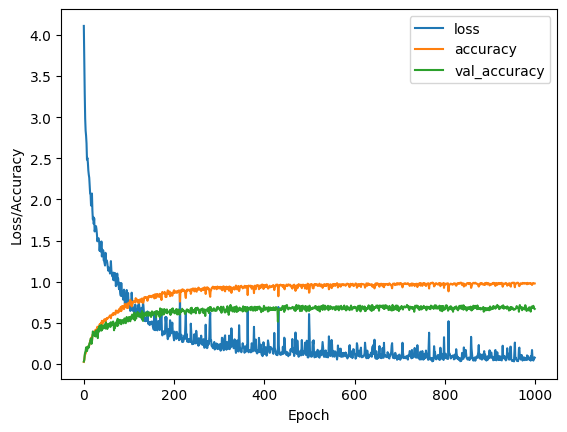

In [31]:
pd.DataFrame.from_dict(result.history)[["loss", "accuracy", "val_accuracy"]].plot()
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")

In [32]:
predictions = model.predict(test_features)
predictions_category_id = [i.argmax() for i in predictions]

10/10 [==============================] - 1s 17ms/step


In [33]:
df_predictions = pd.DataFrame.from_dict({"category": test_target, "prediction": predictions_category_id})
df_predictions["correct"] = df_predictions["category"] == df_predictions["prediction"]
df_predictions

,category,prediction,correct
0,0,0,True
1,0,0,True
2,0,0,True
3,0,0,True
4,0,0,True
...,...,...,...
315,63,63,True
316,63,63,True
317,63,63,True
318,63,63,True


Text(0, 0.5, 'Prediction')

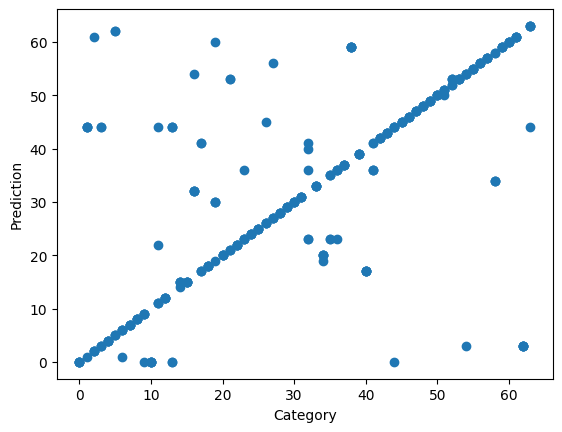

In [34]:
plt.scatter(x=df_predictions["category"], y=df_predictions["prediction"])
plt.xlabel("Category")
plt.ylabel("Prediction")

In [36]:
categories = df_predictions["category"].unique()
categories.sort()
for category in categories:
    df_category = df_predictions[df_predictions["category"] == category]
    correct = len(df_category[df_category["correct"] == True])
    count = len(df_category)
    print("Category:", category)
    print("Correct:", correct)
    print("Wrong:", count - correct)
    print("Precision:", correct/count * 100)
    print("="*16)
    print()

Category: 0
Correct: 5
Wrong: 0
Precision: 100.0

Category: 1
Correct: 1
Wrong: 4
Precision: 20.0

Category: 2
Correct: 4
Wrong: 1
Precision: 80.0

Category: 3
Correct: 3
Wrong: 2
Precision: 60.0

Category: 4
Correct: 5
Wrong: 0
Precision: 100.0

Category: 5
Correct: 3
Wrong: 2
Precision: 60.0

Category: 6
Correct: 4
Wrong: 1
Precision: 80.0

Category: 7
Correct: 5
Wrong: 0
Precision: 100.0

Category: 8
Correct: 5
Wrong: 0
Precision: 100.0

Category: 9
Correct: 4
Wrong: 1
Precision: 80.0

Category: 10
Correct: 0
Wrong: 5
Precision: 0.0

Category: 11
Correct: 3
Wrong: 2
Precision: 60.0

Category: 12
Correct: 5
Wrong: 0
Precision: 100.0

Category: 13
Correct: 0
Wrong: 5
Precision: 0.0

Category: 14
Correct: 1
Wrong: 4
Precision: 20.0

Category: 15
Correct: 5
Wrong: 0
Precision: 100.0

Category: 16
Correct: 0
Wrong: 5
Precision: 0.0

Category: 17
Correct: 3
Wrong: 2
Precision: 60.0

Category: 18
Correct: 5
Wrong: 0
Precision: 100.0

Category: 19
Correct: 1
Wrong: 4
Precision: 20.0

Catego

In [45]:
df_predictions[df_predictions["category"] == 0]

,category,prediction,correct
0,0,0,True
1,0,0,True
2,0,0,True
3,0,0,True
4,0,0,True


In [50]:
df_predictions[df_predictions["correct"] == True]["category"].value_counts()

category
0     5
28    5
30    5
33    5
37    5
39    5
42    5
43    5
45    5
46    5
47    5
48    5
49    5
50    5
53    5
55    5
56    5
57    5
59    5
60    5
61    5
29    5
31    5
15    5
25    5
24    5
4     5
22    5
7     5
20    5
8     5
18    5
12    5
27    4
2     4
6     4
54    4
51    4
9     4
26    4
44    4
36    4
23    4
63    4
17    3
11    3
21    3
35    3
5     3
3     3
52    2
41    2
58    2
14    1
19    1
1     1
Name: count, dtype: int64

In [25]:
# Saving model
model.save("models/asl/model_80_dropout.keras")

In [22]:
# Validation
validation_data = pd.read_csv("validate_dataset.csv")

In [23]:
validation_data

,Unnamed: 0,category,video_name,frame,hand_0_wrist_x,hand_0_wrist_y,hand_0_wrist_z,hand_0_thumb_cmc_x,hand_0_thumb_cmc_y,hand_0_thumb_cmc_z,...,pose_right_heel_z,pose_left_heel_x,pose_left_heel_y,pose_left_heel_z,pose_right_foot_index_x,pose_right_foot_index_y,pose_right_foot_index_z,pose_left_foot_index_x,pose_left_foot_index_y,pose_left_foot_index_z
0,0,0,hello.mp4,0,0.778732,0.533119,1.618656e-07,0.760882,0.535324,-0.018034,...,0.395898,0.572077,0.911452,0.501065,0.719199,0.972017,0.119681,0.488783,0.955139,0.242829
1,1,0,hello.mp4,1,0.780349,0.531990,2.006781e-07,0.765526,0.535483,-0.019550,...,0.411669,0.572511,0.911294,0.488532,0.719056,0.971016,0.124615,0.489077,0.955218,0.222932
2,2,0,hello.mp4,2,0.789860,0.532102,1.953509e-07,0.769175,0.535249,-0.012909,...,0.398743,0.574021,0.911196,0.440281,0.718746,0.970221,0.106521,0.489621,0.955267,0.175936
3,3,0,hello.mp4,3,0.788924,0.532276,2.103518e-07,0.768380,0.534756,-0.015882,...,0.436644,0.574857,0.911146,0.453911,0.718660,0.969597,0.106942,0.489658,0.955268,0.162054
4,4,0,hello.mp4,4,0.349383,0.268837,4.599055e-10,0.370172,0.267407,-0.015195,...,0.501966,0.575456,0.910632,0.530033,0.716889,0.969052,0.172926,0.490454,0.955318,0.231649
5,5,0,hello.mp4,5,0.785580,0.531081,2.303617e-07,0.761963,0.533857,-0.015278,...,0.544538,0.575521,0.909889,0.595152,0.716690,0.969041,0.227990,0.491607,0.955701,0.317404
6,6,0,hello.mp4,6,0.441508,0.162445,1.070640e-07,0.467898,0.163019,-0.007401,...,0.521477,0.575575,0.909088,0.603336,0.715843,0.969006,0.203265,0.492571,0.955709,0.331097
7,7,0,hello.mp4,7,0.465447,0.166934,1.335545e-07,0.497158,0.169014,-0.003429,...,0.531344,0.575584,0.907475,0.638983,0.714891,0.969012,0.206211,0.493177,0.955663,0.364467
8,8,0,hello.mp4,8,0.471391,0.166036,1.390416e-07,0.500977,0.170404,-0.007057,...,0.523898,0.574160,0.907230,0.632156,0.714896,0.969352,0.198824,0.493277,0.955528,0.354292
9,9,0,hello.mp4,9,0.464834,0.160303,1.670441e-07,0.493160,0.164720,-0.007812,...,0.560217,0.573337,0.907003,0.647405,0.714541,0.969358,0.225727,0.493262,0.955509,0.362772


In [24]:
validation_data = validation_data.drop(["Unnamed: 0", "category", "video_name", "frame"], axis=1).values

In [45]:
validation_data = validation_data.reshape((int(validation_data.shape[0]/frames), frames, validation_data.shape[1]))

In [46]:
validation_data.shape

(1, 30, 1623)

In [47]:
result = model.predict(validation_data)

1/1 [==============================] - 0s 17ms/step


In [50]:
result.argmax()

3